In [14]:

import pandas as pd
import numpy as np
import pywt
import pandas as pd 
from scipy.stats import skew, kurtosis, median_abs_deviation, moment
import math 
import scipy
import matplotlib.pyplot as plt 
import pywt
import pandas as pd 
import copy
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import lime
from lime import lime_tabular

In [15]:
def rmsValue(array):
    n = len(array)
    squre = 0.0
    root = 0.0
    mean = 0.0
    for i in range(0, n):
        squre += (array[i] ** 2)
    mean = (squre/ (float)(n))
    root = math.sqrt(mean)
    return root

def peak_to_rms_1D(array):

    return np.max(np.abs(array))/rmsValue(array)

def signal_range_1D(array):

    return np.max(array) - np.min(array)


def stats_from_WD(s_signal, wv_type, decomp_lvl):
    coeffs  = pywt.wavedec(s_signal, wv_type, level = decomp_lvl)
    ft_vec = []

    for comp in coeffs:
     ft_vec.append( [np.mean(comp), np.var(comp), np.std(comp), rmsValue(comp),
                   skew(comp), kurtosis(comp), peak_to_rms_1D(comp), rmsValue(comp)/np.mean(np.abs(comp)),
                      median_abs_deviation(comp), moment(comp, moment=2), np.min(comp),
                     np.max(comp), signal_range_1D(comp)] )

    ft_vec = np.reshape(ft_vec, (len(coeffs)*len(ft_vec[0])),) # 1,52
    return ft_vec


def get_train_ft(train_data, dc_type,  dc_lvl):
    
    train_features = []
    for i in range(len(train_data)):
        ft_vec = stats_from_WD(train_data[i,:], dc_type, dc_lvl)
        train_features.append(ft_vec)


    train_features = np.array(train_features)
    
    return train_features

In [16]:
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')
train_labels = train_data.iloc[:,-1]
train_labels = np.array(train_labels, dtype=np.int16)
feat_type = "DWT"    
standard_scaler = True 

if feat_type == "Time":
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   #train_data = sc.fit_transform(train_data)
elif feat_type == "DWT":
   dwt_base = "db4"
   dwt_dc_level = 3
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   print("Extracting DWT-based features\n")
   train_data = get_train_ft(train_data, dwt_base, dwt_dc_level)


train_labels[train_labels != 1] = 0 # 1 - sezure, 0 - no seizure
n_lab = np.unique(train_labels)   
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.33, random_state=42)

if standard_scaler:
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)


counts = []
for i in range(len(n_lab)):
    counts.append(np.sum(train_labels==i))
counts = counts/sum(counts)

print(f"Train data labels distributions: {counts*100}\n")

Extracting DWT-based features

Train data labels distributions: [80.14276444 19.85723556]



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 52, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 52, 64)    │        256 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 52, 64)    │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 52, 64)    │     12,352 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 52, 64)    │        128 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 52, 64)    │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 52, 64)    │          0 │ conv1d_20[0][0],  │
│                     │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 52, 64)    │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 52, 64)    │     12,352 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 52, 64)    │          0 │ conv1d_21[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 52, 64)    │     12,352 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 52, 64)    │          0 │ conv1d_22[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 52, 64)    │          0 │ activation_8[0][… │
│                     │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 52, 64)    │          0 │ add_9[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 52, 64)    │     12,352 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 52, 64)    │          0 │ conv1d_23[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 52, 64)    │     12,352 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 52, 64)    │          0 │ conv1d_24[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 52, 64)    │          0 │ activation_9[0][… │
│                     │                   │            │ dropout_21[0][0]

 Total params: 103,489 (404.25 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8980 - loss: 0.2667 - val_accuracy: 0.9533 - val_loss: 0.1373
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9562 - loss: 0.1343 - val_accuracy: 0.9637 - val_loss: 0.1118
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9608 - loss: 0.1120 - val_accuracy: 0.9624 - val_loss: 0.1080
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9639 - loss: 0.0996 - val_accuracy: 0.9650 - val_loss: 0.0871
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9634 - loss: 0.0956 - val_accuracy: 0.9663 - val_loss: 0.0842
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9709 - loss: 0.0772 - val_accuracy: 0.9585 - val_loss: 0.0977
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9709 - loss: 0.0828 - val_accuracy: 0.9702 - val_loss: 0.0892
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9700 - loss: 0.0766 - val_accu

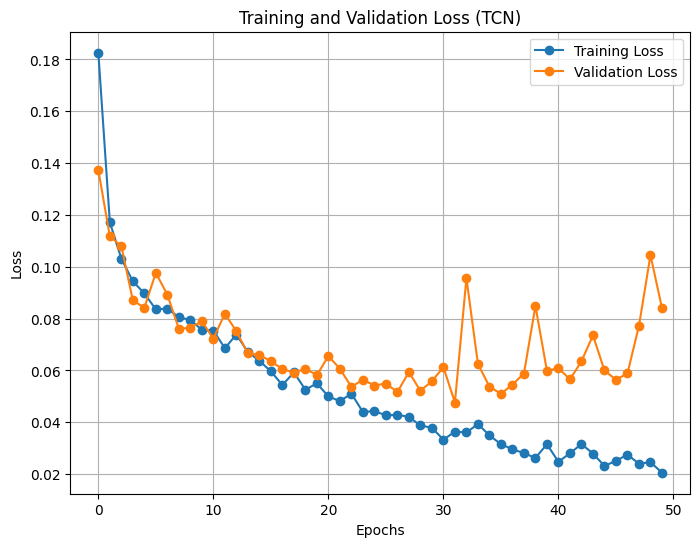

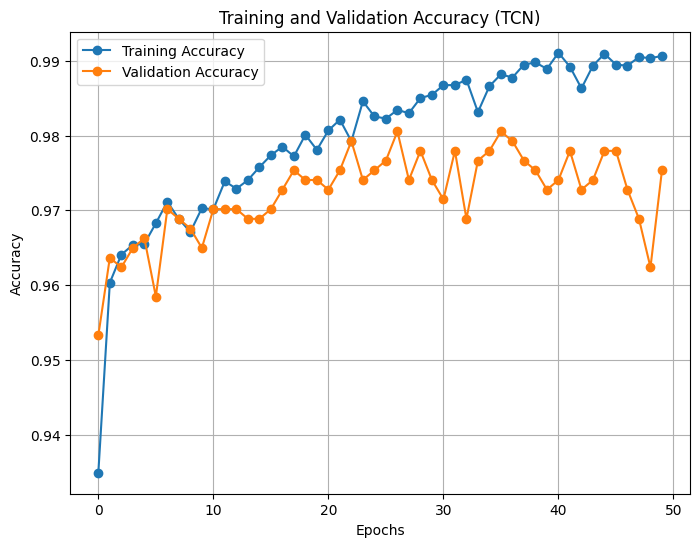

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9776 - loss: 0.0768
Test accuracy (TCN): 97.42%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report (TCN):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3025
           1       0.90      0.98      0.94       770

    accuracy                           0.97      3795
   macro avg       0.95      0.97      0.96      3795
weighted avg       0.98      0.97      0.97      3795



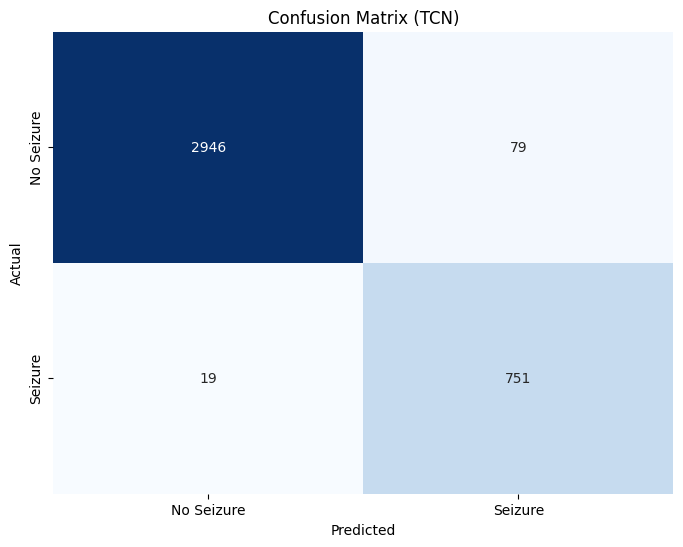

In [13]:
# Reshape data for TCN model
from tensorflow.keras import initializers
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

# Now, train_data.shape will be (7705, 52, 1)
# and test_data.shape will be (3795, 52, 1)

def create_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    """
    Creates a Temporal Convolutional Network (TCN) model.
    
    Parameters:
    - input_shape: tuple, shape of the input data (timesteps, features)
    - num_filters: int, number of filters for the Conv1D layers
    - kernel_size: int, size of the convolutional kernel
    - num_blocks: int, number of residual blocks
    - dropout_rate: float, dropout rate for regularization
    
    Returns:
    - model: Compiled TCN model
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        # First Conv1D layer in the residual block
        conv1 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(x)
        conv1 = layers.Dropout(dropout_rate)(conv1)
        
        # Second Conv1D layer in the residual block
        conv2 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(conv1)
        conv2 = layers.Dropout(dropout_rate)(conv2)
        
        # Residual connection
        if x.shape[-1] != conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, conv2])
        x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create TCN model
tcn_model = create_tcn(input_shape)

# Compile the model
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
tcn_model.summary()

# Train the model
history = tcn_model.fit(train_data, train_labels, epochs=50, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_tcn = tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (TCN): {test_acc_tcn*100:.2f}%')

# Predict on test data
predictions = tcn_model.predict(test_data)
predictions_binary = (predictions > 0.50).astype(int)

# Classification Report
print("Classification Report (TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 52, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 52, 32)    │        128 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 26, 32)    │          0 │ conv1d_47[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 26, 64)    │      6,208 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 13, 64)    │          0 │ conv1d_48[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 13, 64)    │     12,352 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 13, 64)    │          0 │ conv1d_49[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 13, 64)    │     12,352 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 13, 64)    │          0 │ conv1d_50[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 13, 64)    │          0 │ max_pooling1d_5[… │
│                     │                   │            │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 13, 64)    │          0 │ add_20[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 13, 64)    │     12,352 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 13, 64)    │          0 │ conv1d_51[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 13, 64)    │     12,352 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 13, 64)    │          0 │ conv1d_52[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 13, 64)    │          0 │ activation_20[0]… │
│                     │                   │            │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 13, 64)    │          0 │ add_21[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 13, 64)    │     12,352 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 13, 64)    │          0 │ conv1d_53[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 121,793 (475.75 KB)

 Trainable params: 121,793 (475.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9229 - loss: 0.2394 - val_accuracy: 0.9637 - val_loss: 0.0972
Epoch 2/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9710 - loss: 0.0788 - val_accuracy: 0.9507 - val_loss: 0.1204
Epoch 3/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9706 - loss: 0.0782 - val_accuracy: 0.9676 - val_loss: 0.0911
Epoch 4/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9727 - loss: 0.0691 - val_accuracy: 0.9689 - val_loss: 0.0767
Epoch 5/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9741 - loss: 0.0669 - val_accuracy: 0.9728 - val_loss: 0.0773
Epoch 6/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9741 - loss: 0.0628 - val_accuracy: 0.9715 - val_loss: 0.0929
Epoch 7/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9756 - loss: 0.0613 - val_accuracy: 0.9741 - val_loss: 0.0685
Epoch 8/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9757 - loss: 0.0599 - val_accuracy: 0.

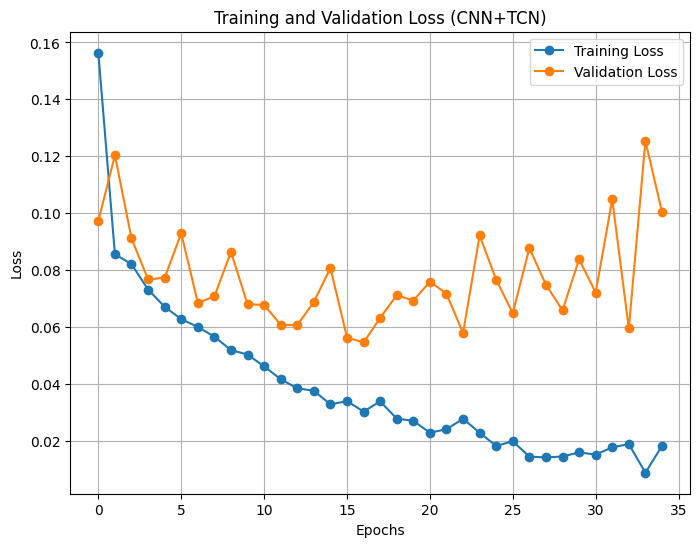

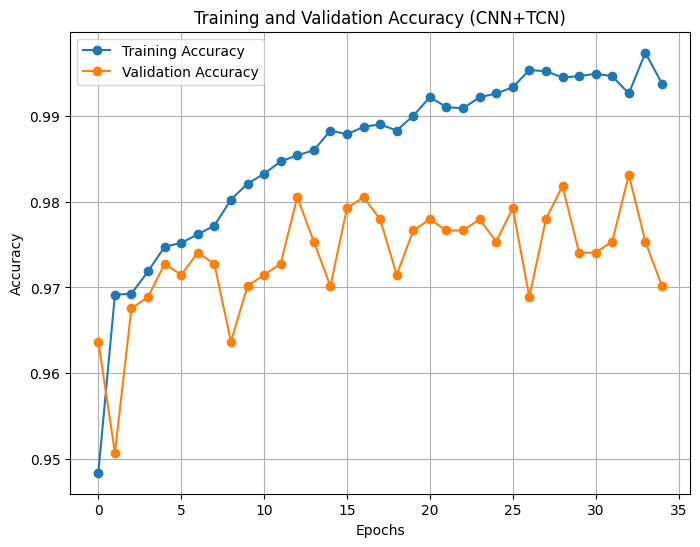

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0633
Test accuracy (CNN+TCN): 98.23%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report (CNN+TCN):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.95      0.96      0.96       770

    accuracy                           0.98      3795
   macro avg       0.97      0.97      0.97      3795
weighted avg       0.98      0.98      0.98      3795



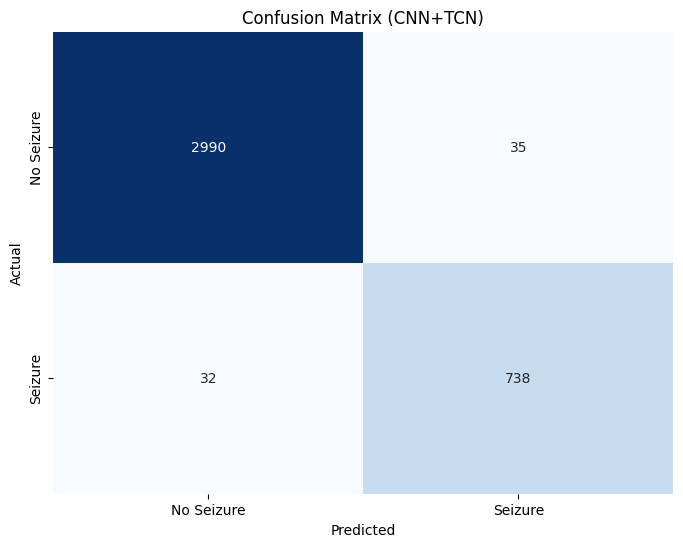

In [16]:
# Reshape data if necessary
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

def create_cnn_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    
    # CNN part
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # TCN part
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        tcn_conv1 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(x)
        tcn_conv1 = layers.Dropout(dropout_rate)(tcn_conv1)
        
        tcn_conv2 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(tcn_conv1)
        tcn_conv2 = layers.Dropout(dropout_rate)(tcn_conv2)
        
        if x.shape[-1] != tcn_conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, tcn_conv2])
        x = layers.Activation('relu')(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create CNN+TCN model
cnn_tcn_model = create_cnn_tcn(input_shape)

# Compile the model
cnn_tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn_tcn_model.summary()

# Train the model
history = cnn_tcn_model.fit(train_data, train_labels, epochs=35, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_cnn_tcn = cnn_tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN+TCN): {test_acc_cnn_tcn*100:.2f}%')

# Predict on test data
predictions = cnn_tcn_model.predict(test_data)
predictions_binary = (predictions > 0.5).astype(int)

# Classification Report
print("Classification Report (CNN+TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (CNN+TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1D-CNN MODEL

Epoch 1/22


/home/rakesh018/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7585 - loss: 1.0037 - val_accuracy: 0.9611 - val_loss: 0.1772
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9706 - loss: 0.1059 - val_accuracy: 0.9780 - val_loss: 0.0522
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9823 - loss: 0.0542 - val_accuracy: 0.9831 - val_loss: 0.0415
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9852 - loss: 0.0394 - val_accuracy: 0.9715 - val_loss: 0.1411
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9803 - loss: 0.0529 - val_accuracy: 0.9831 - val_loss: 0.0544
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9889 - loss: 0.0314 - val_accuracy: 0.9896 - val_loss: 0.0311
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9924 - loss: 0.0276 - val_accuracy: 0.9754 - val_loss: 0.0582
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9832 - loss: 0.0448 - val_accuracy: 0.9883 - val_

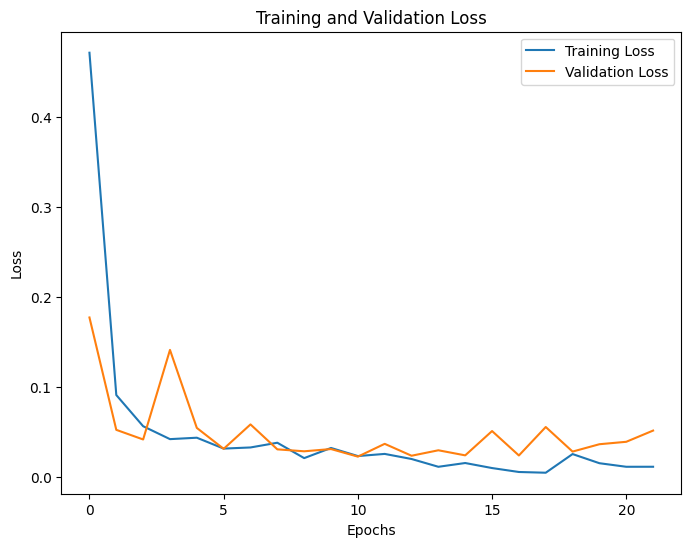

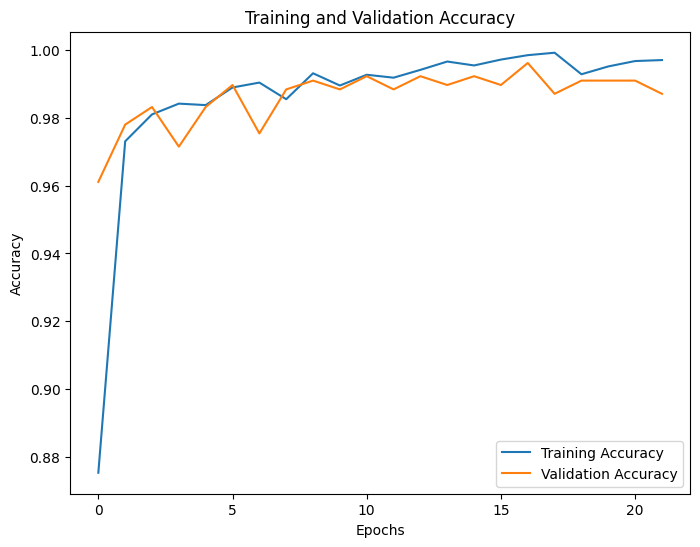

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9868 - loss: 0.0545
Test accuracy (CNN): 98.57707619667053%
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3025
           1       0.95      0.98      0.97       770

    accuracy                           0.99      3795
   macro avg       0.97      0.98      0.98      3795
weighted avg       0.99      0.99      0.99      3795



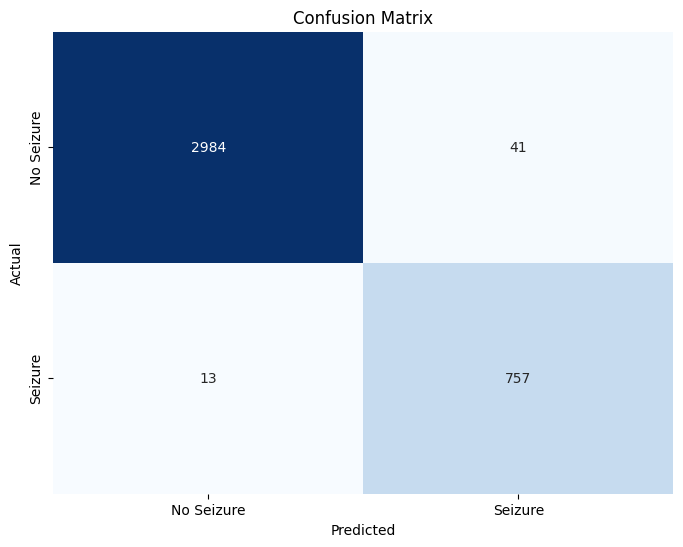

In [48]:
#CNN
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=5, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
    
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]
model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc_cnn = model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


LSTM MODEL

Epoch 1/22
217/217 [==============================] - 17s 49ms/step - loss: 0.2051 - accuracy: 0.9376 - val_loss: 0.1606 - val_accuracy: 0.9507
Epoch 2/22
217/217 [==============================] - 9s 40ms/step - loss: 0.1527 - accuracy: 0.9476 - val_loss: 0.1554 - val_accuracy: 0.9429
Epoch 3/22
217/217 [==============================] - 9s 40ms/step - loss: 0.1396 - accuracy: 0.9528 - val_loss: 0.1244 - val_accuracy: 0.9559
Epoch 4/22
217/217 [==============================] - 9s 41ms/step - loss: 0.1345 - accuracy: 0.9540 - val_loss: 0.1213 - val_accuracy: 0.9585
Epoch 5/22
217/217 [==============================] - 10s 44ms/step - loss: 0.1300 - accuracy: 0.9546 - val_loss: 0.1238 - val_accuracy: 0.9572
Epoch 6/22
217/217 [==============================] - 9s 41ms/step - loss: 0.1265 - accuracy: 0.9543 - val_loss: 0.1168 - val_accuracy: 0.9611
Epoch 7/22
217/217 [==============================] - 9s 40ms/step - loss: 0.1219 - accuracy: 0.9554 - val_loss: 0.1175 - val_accuracy: 0.95

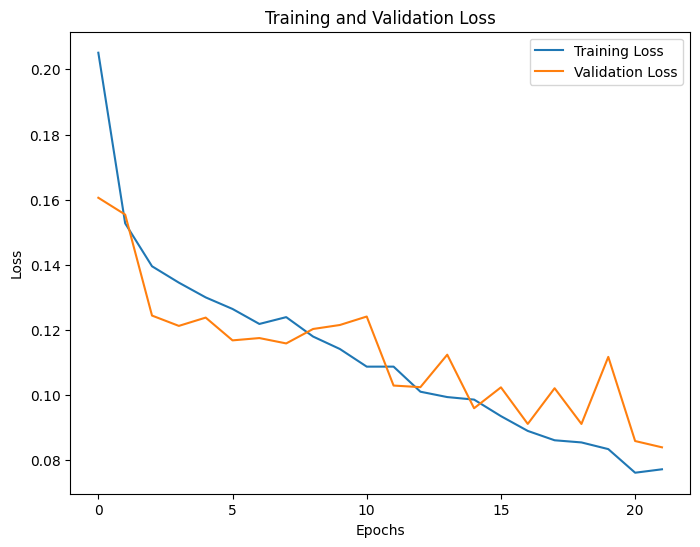

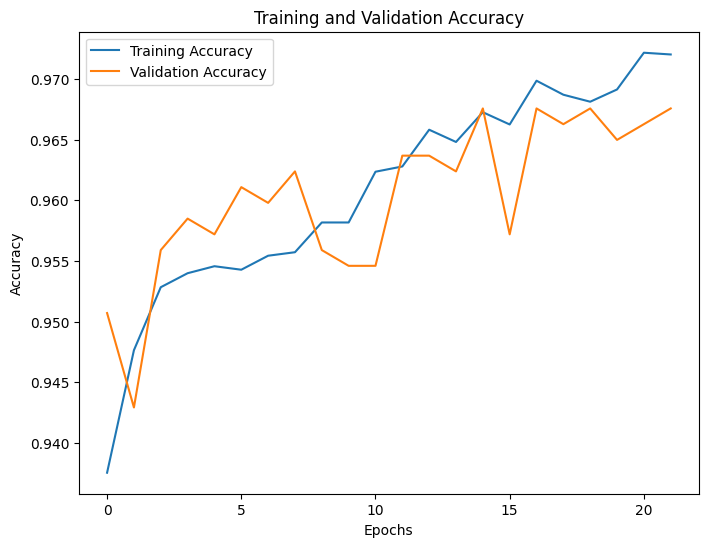

119/119 [==============================] - 2s 14ms/step - loss: 0.0896 - accuracy: 0.9694
Test accuracy (LSTM): 96.94334864616394%
119/119 [==============================] - 3s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.91      0.92       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.95      3795
weighted avg       0.97      0.97      0.97      3795



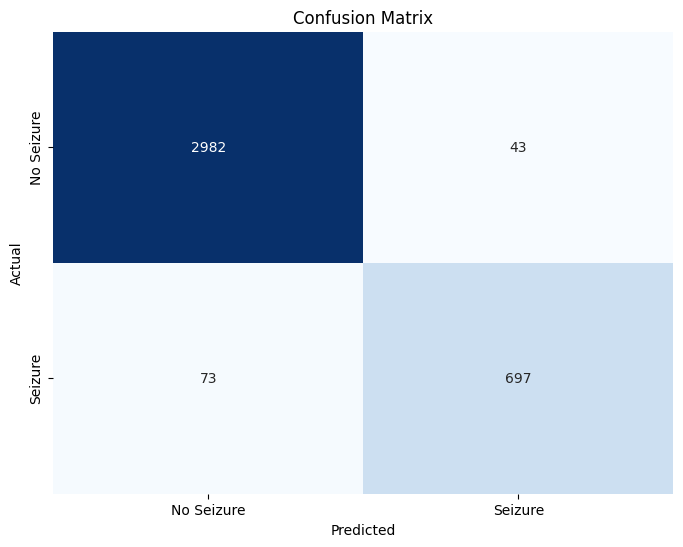

In [27]:
#LSTM
def create_lstm(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))  # Return sequences for stacking LSTM layers
    model.add(layers.LSTM(32, return_sequences=True))  # Additional LSTM layer
    model.add(layers.LSTM(32))  # Additional LSTM layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))
input_shape = train_data.shape[1:]
model = create_lstm(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)
# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc_lstm = model.evaluate(test_data, test_labels)
print(f'Test accuracy (LSTM): {test_acc_lstm*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

CNN + LSTM ENSEMBLE LEARNING MODEL

Epoch 1/11
217/217 [==============================] - 4s 11ms/step - loss: 0.1654 - accuracy: 0.9469 - val_loss: 0.1056 - val_accuracy: 0.9637
Epoch 2/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0893 - accuracy: 0.9670 - val_loss: 0.0834 - val_accuracy: 0.9702
Epoch 3/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0672 - accuracy: 0.9740 - val_loss: 0.1067 - val_accuracy: 0.9507
Epoch 4/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0566 - accuracy: 0.9765 - val_loss: 0.0986 - val_accuracy: 0.9650
Epoch 5/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0496 - accuracy: 0.9781 - val_loss: 0.0813 - val_accuracy: 0.9650
Epoch 6/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0552 - accuracy: 0.9782 - val_loss: 0.0771 - val_accuracy: 0.9637
Epoch 7/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0448 - accuracy: 0.9830 - val_loss: 0.0708 - val_accuracy: 0.9663
Epoch

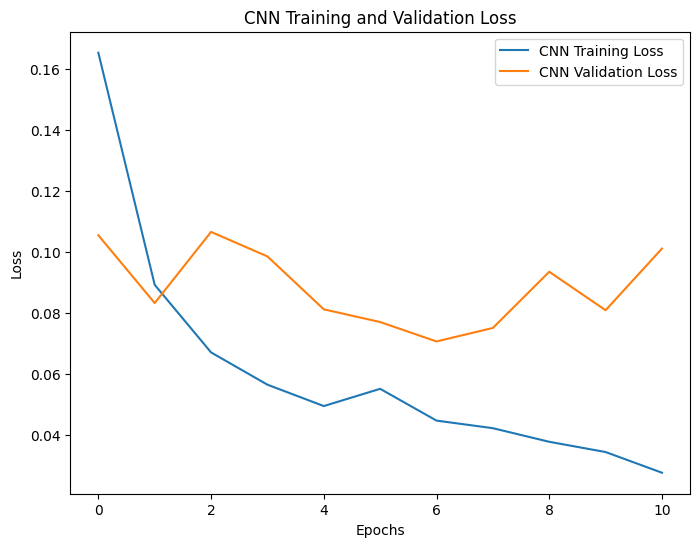

119/119 [==============================] - 3s 14ms/step
Ensemble Model Test Accuracy: 97.65480895915678%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.92      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



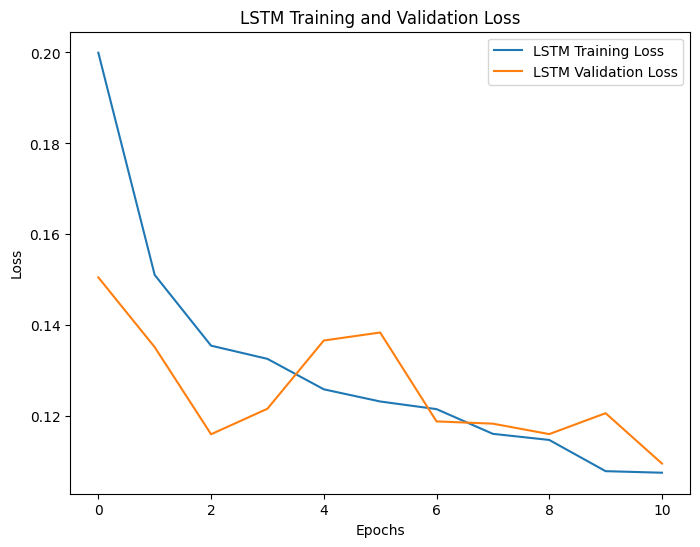

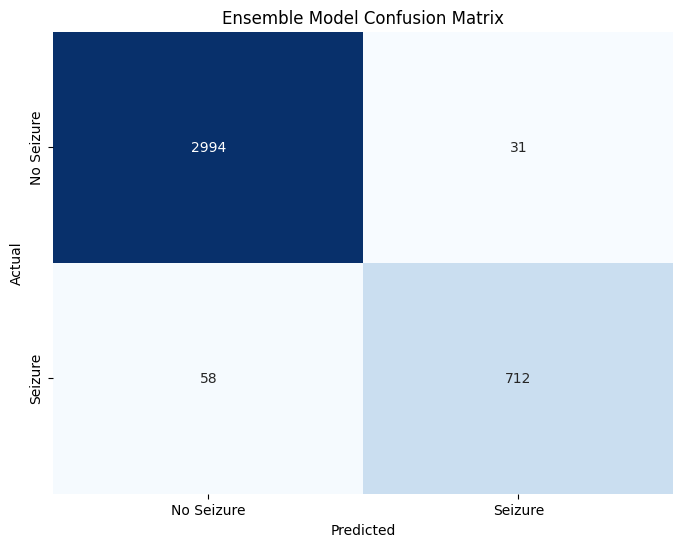

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, concatenate, Dropout
from sklearn.metrics import accuracy_score

# Define CNN model
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
    

# Define LSTM model
def create_lstm(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))  # Return sequences for stacking LSTM layers
    model.add(layers.LSTM(32, return_sequences=True))  # Additional LSTM layer
    model.add(layers.LSTM(32))  # Additional LSTM layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model

# Create CNN model
cnn_model = create_cnn(input_shape)

# Create LSTM model
lstm_model = create_lstm(input_shape)

# Compile CNN and LSTM models
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN and LSTM models
cnn_history = cnn_model.fit(train_data, train_labels, epochs=11, batch_size=32, validation_split=0.1)
lstm_history = lstm_model.fit(train_data, train_labels, epochs=11, batch_size=32, validation_split=0.1)

# Plotting training and validation loss for CNN
plt.figure(figsize=(8, 6))
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation loss for LSTM
plt.figure(figsize=(8, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Make predictions using CNN and LSTM models
cnn_predictions = cnn_model.predict(test_data)
lstm_predictions = lstm_model.predict(test_data)

# Combine predictions using simple averaging
ensemble_predictions = (cnn_predictions + lstm_predictions) / 2

# Convert probabilities to binary predictions
ensemble_predictions_binary = (ensemble_predictions > 0.5).astype(int)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(test_labels, ensemble_predictions_binary)
print(f'Ensemble Model Test Accuracy: {ensemble_accuracy*100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)

conf_matrix = confusion_matrix(test_labels, ensemble_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


DECISION TREE MODEL

Decision Tree Classifier Accuracy: 96.83794466403161%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3025
           1       0.92      0.93      0.92       770

    accuracy                           0.97      3795
   macro avg       0.95      0.95      0.95      3795
weighted avg       0.97      0.97      0.97      3795



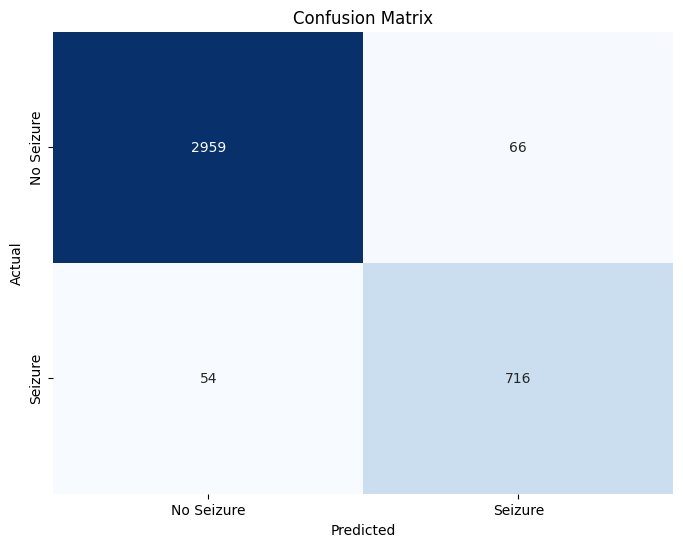

In [31]:
#DecisionTreeClassifier
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_data, train_labels)
dt_predictions = dt_classifier.predict(test_data)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f'Decision Tree Classifier Accuracy: {dt_accuracy*100}%')
print("Classification Report:")
print(classification_report(test_labels, dt_predictions))
conf_matrix = confusion_matrix(test_labels, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




RANDOM FOREST MODEL

Random Forest Classifier Accuracy: 98.20816864295125%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.95      0.96      0.96       770

    accuracy                           0.98      3795
   macro avg       0.97      0.97      0.97      3795
weighted avg       0.98      0.98      0.98      3795



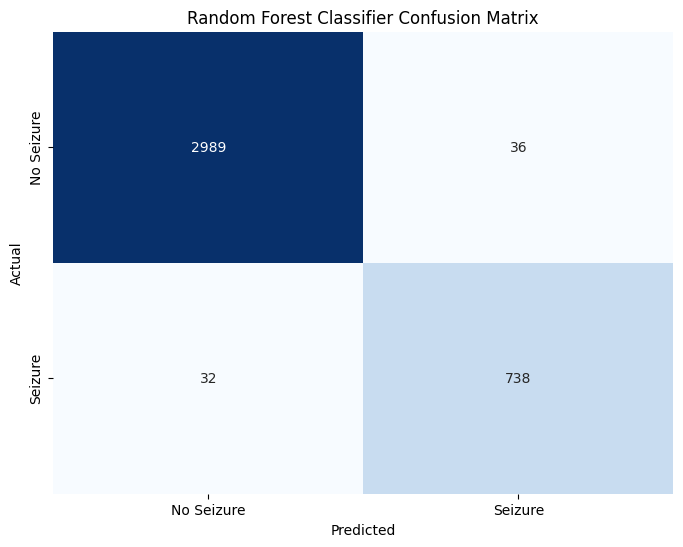

In [32]:
from sklearn.ensemble import RandomForestClassifier

train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_data_reshaped, train_labels)
predictions = random_forest_classifier.predict(test_data_reshaped)
rf_accuracy = accuracy_score(test_labels, predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy * 100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
rf_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



ADA BOOSTING

/home/rakesh018/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Accuracy: 97.60210803689064%
AdaBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3025
           1       0.93      0.95      0.94       770

    accuracy                           0.98      3795
   macro avg       0.96      0.97      0.96      3795
weighted avg       0.98      0.98      0.98      3795



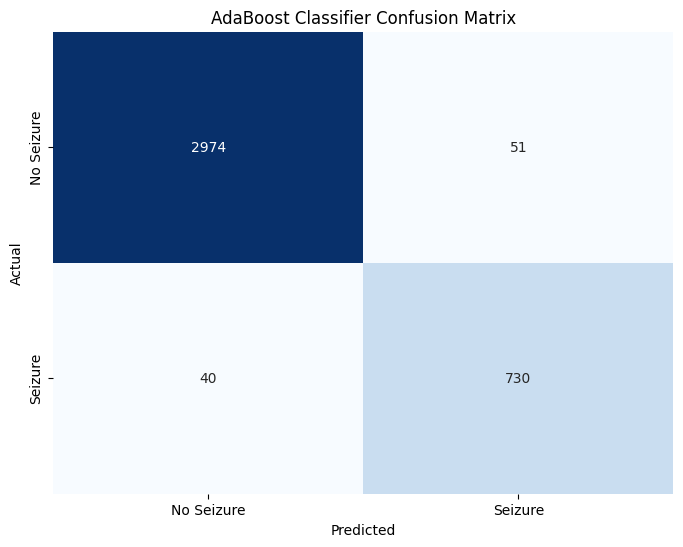

In [34]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_classifier.fit(train_data, train_labels)
adaboost_predictions = adaboost_classifier.predict(test_data)
adaboost_accuracy = accuracy_score(test_labels, adaboost_predictions)
print(f'AdaBoost Classifier Accuracy: {adaboost_accuracy*100}%')
print("AdaBoost Classifier Classification Report:")
print(classification_report(test_labels, adaboost_predictions))
adaboost_conf_matrix = confusion_matrix(test_labels, adaboost_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("AdaBoost Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM MODEL

SVM Classifier Test Accuracy: 97.78656126482214%
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.95      0.94      0.95       770

    accuracy                           0.98      3795
   macro avg       0.97      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



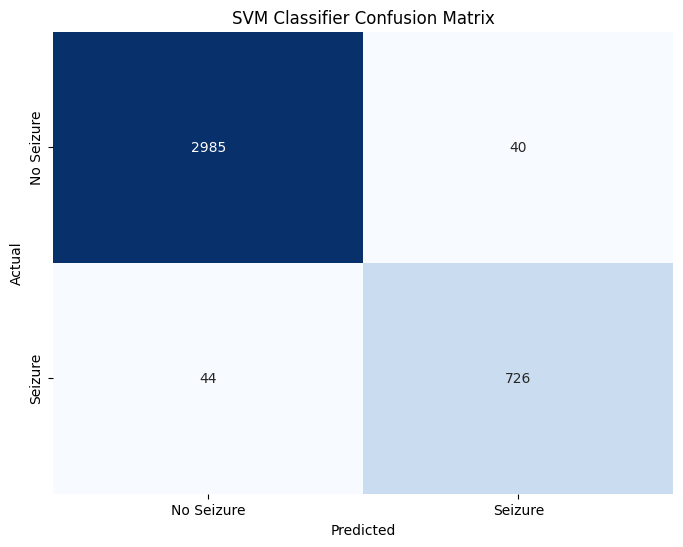

In [35]:
#SVM
from sklearn.svm import SVC
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(train_data, train_labels)
svm_predictions = svm_classifier.predict(test_data)
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Classifier Test Accuracy: {svm_accuracy*100}%')
print("SVM Classifier Classification Report:")
print(classification_report(test_labels, svm_predictions))
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("SVM Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

KNN MODEL

KNN Classifier Accuracy: 97.15415019762847%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.92      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



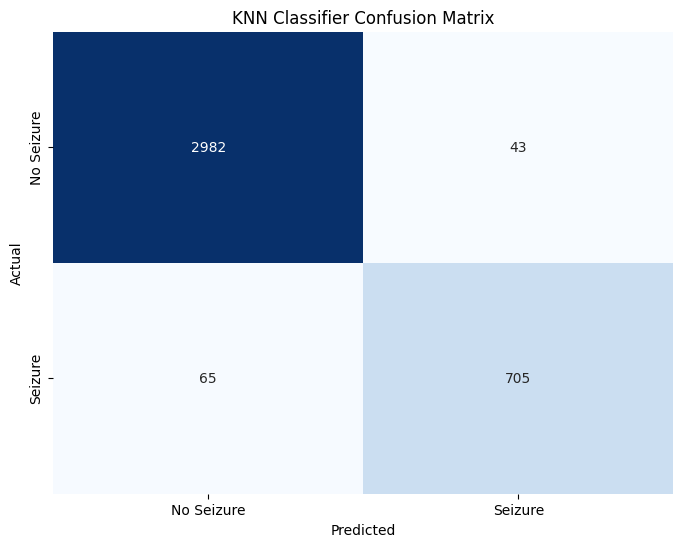

In [36]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn_classifier = KNeighborsClassifier(n_neighbors=5)  

knn_classifier.fit(train_data, train_labels)

# Predict on the test data
predictions = knn_classifier.predict(test_data)
knn_accuracy = accuracy_score(test_labels, predictions)
print(f"KNN Classifier Accuracy: {knn_accuracy * 100}%")
print("KNN Classification Report:")
print(classification_report(test_labels, predictions))
knn_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("KNN Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [37]:
import matplotlib.pyplot as plt

accuracy_scores = [knn_accuracy, svm_accuracy, dt_accuracy, rf_accuracy,adaboost_accuracy, test_acc_cnn,test_acc_lstm,ensemble_accuracy]
classifier_names = ['KNN', 'SVM', 'DCT', 'RF', 'ADA', 'CNN','LSTM','CNN+LSTM']

plt.figure(figsize=(12, 7)) 
bars = plt.bar(classifier_names, accuracy_scores, color=['purple', 'blue', 'red', 'green', 'lavender', 'orange', 'pink','yellow'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy")
plt.ylim(0, 1)  

for bar, label in zip(bars, accuracy_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(label, 2), ha='center', va='bottom')

plt.show()

NameError: name 'test_acc_cnn' is not defined

In [ ]:
DIRECTLY USING THE SIGNAL DATA INSTEAD OF FEATURE EXTRACTION AND COMPARE

In [41]:
# Load the dataset
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')

# Extract labels (assuming the last column contains the labels)
train_labels = train_data.iloc[:, -1].values
train_labels[train_labels != 1] = 0 # 1 - sezure, 0 - no seizure

# Drop the first column and the label column from the features
train_data = train_data.iloc[:, 1:-1].values

# Split the data into 67% training and 33% testing
train_data, test_data, train_labels, test_labels = train_test_split(
    train_data, train_labels, test_size=0.33, random_state=42)

# Print the shapes of the resulting datasets
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train data shape: (7705, 178)
Test data shape: (3795, 178)
Train labels shape: (7705,)
Test labels shape: (3795,)


Decision Tree Classifier Accuracy: 94.39%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3025
           1       0.88      0.84      0.86       770

    accuracy                           0.94      3795
   macro avg       0.92      0.91      0.91      3795
weighted avg       0.94      0.94      0.94      3795



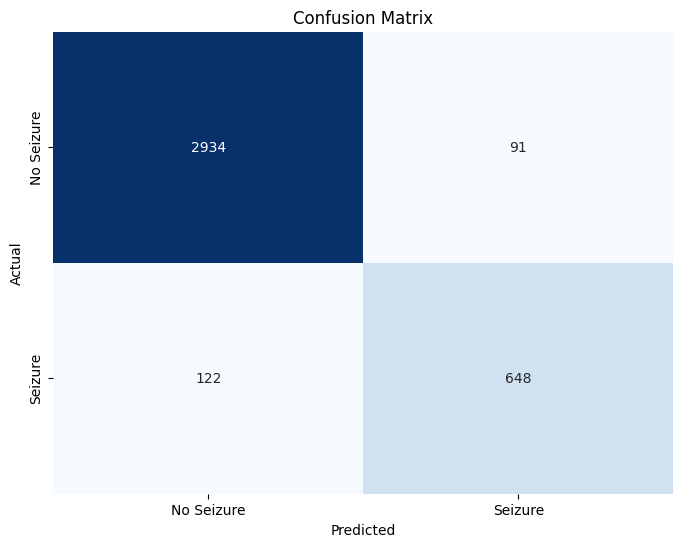

In [42]:
#DecisionTreeClassifier
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_data, train_labels)

# Make predictions on the test set
dt_predictions = dt_classifier.predict(test_data)

# Calculate accuracy
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f'Decision Tree Classifier Accuracy: {dt_accuracy*100:.2f}%')

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, dt_predictions))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_labels, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest Classifier Accuracy: 97.31225296442688%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3025
           1       0.94      0.93      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.96      0.96      3795
weighted avg       0.97      0.97      0.97      3795



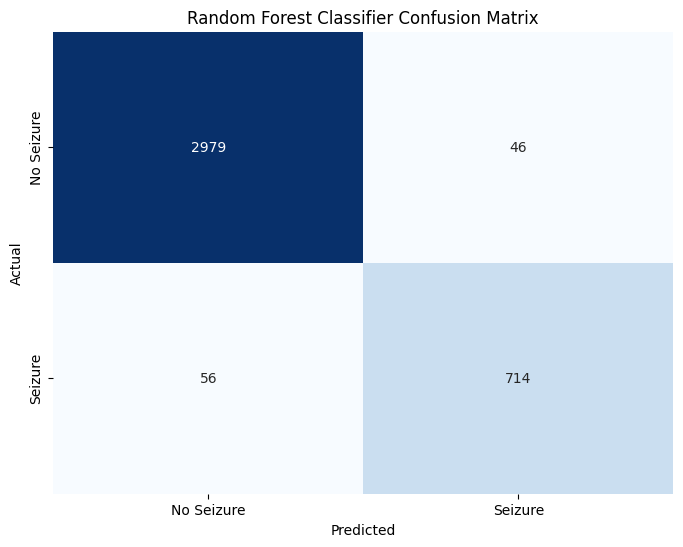

In [43]:
from sklearn.ensemble import RandomForestClassifier

train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_data_reshaped, train_labels)
predictions = random_forest_classifier.predict(test_data_reshaped)
rf_accuracy = accuracy_score(test_labels, predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy * 100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
rf_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/home/rakesh018/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Accuracy: 94.2292490118577%
AdaBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3025
           1       0.89      0.82      0.85       770

    accuracy                           0.94      3795
   macro avg       0.92      0.90      0.91      3795
weighted avg       0.94      0.94      0.94      3795



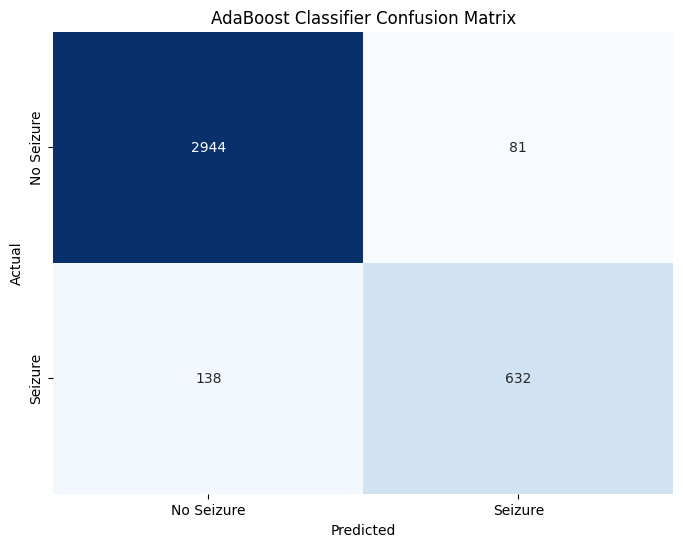

In [44]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_classifier.fit(train_data, train_labels)
adaboost_predictions = adaboost_classifier.predict(test_data)
adaboost_accuracy = accuracy_score(test_labels, adaboost_predictions)
print(f'AdaBoost Classifier Accuracy: {adaboost_accuracy*100}%')
print("AdaBoost Classifier Classification Report:")
print(classification_report(test_labels, adaboost_predictions))
adaboost_conf_matrix = confusion_matrix(test_labels, adaboost_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("AdaBoost Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM Classifier Test Accuracy: 97.23320158102767%
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.96      0.90      0.93       770

    accuracy                           0.97      3795
   macro avg       0.97      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



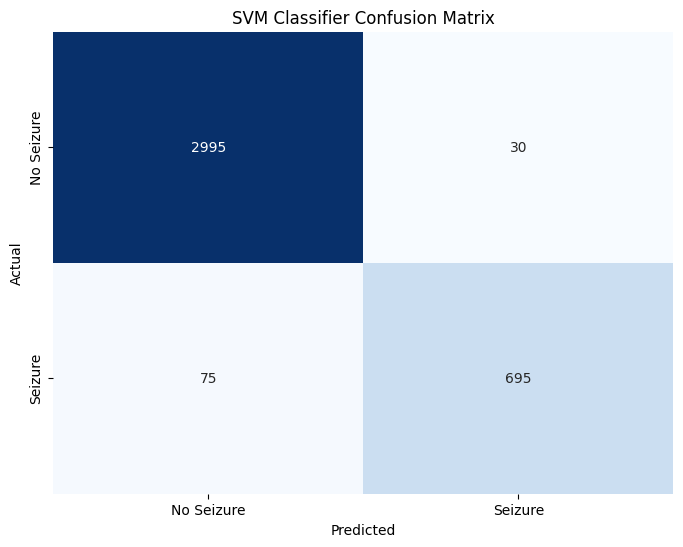

In [45]:
#SVM
from sklearn.svm import SVC
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(train_data, train_labels)
svm_predictions = svm_classifier.predict(test_data)
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Classifier Test Accuracy: {svm_accuracy*100}%')
print("SVM Classifier Classification Report:")
print(classification_report(test_labels, svm_predictions))
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("SVM Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

KNN Classifier Accuracy: 91.9631093544137%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3025
           1       0.99      0.61      0.75       770

    accuracy                           0.92      3795
   macro avg       0.95      0.80      0.85      3795
weighted avg       0.93      0.92      0.91      3795



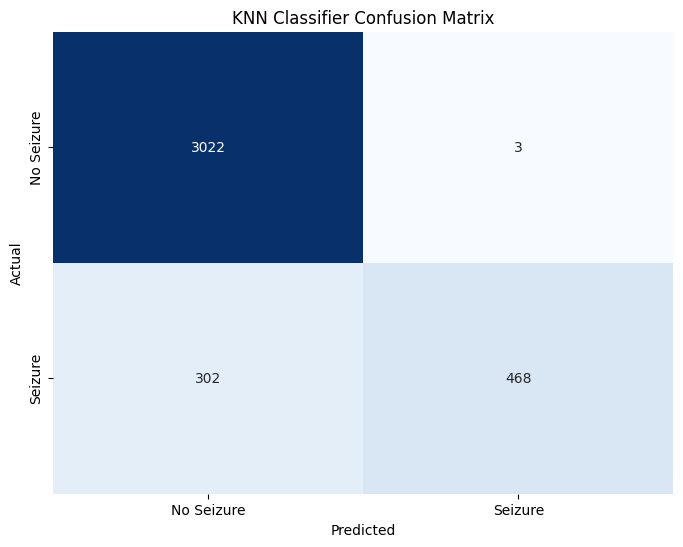

In [39]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn_classifier = KNeighborsClassifier(n_neighbors=5)  

knn_classifier.fit(train_data, train_labels)

# Predict on the test data
predictions = knn_classifier.predict(test_data)
knn_accuracy = accuracy_score(test_labels, predictions)
print(f"KNN Classifier Accuracy: {knn_accuracy * 100}%")
print("KNN Classification Report:")
print(classification_report(test_labels, predictions))
knn_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("KNN Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/22


/home/rakesh018/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7144 - loss: 0.6691 - val_accuracy: 0.9209 - val_loss: 0.3070
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9449 - loss: 0.1893 - val_accuracy: 0.9844 - val_loss: 0.0732
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9793 - loss: 0.0603 - val_accuracy: 0.9702 - val_loss: 0.0738
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9837 - loss: 0.0550 - val_accuracy: 0.9857 - val_loss: 0.0674
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9821 - loss: 0.0512 - val_accuracy: 0.9857 - val_loss: 0.0378
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9877 - loss: 0.0422 - val_accuracy: 0.9883 - val_loss: 0.0354
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9885 - loss: 0.0304 - val_accuracy: 0.9831 - val_loss: 0.0615
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9897 - loss: 0.0305 - val_accuracy: 0.9844 - val_

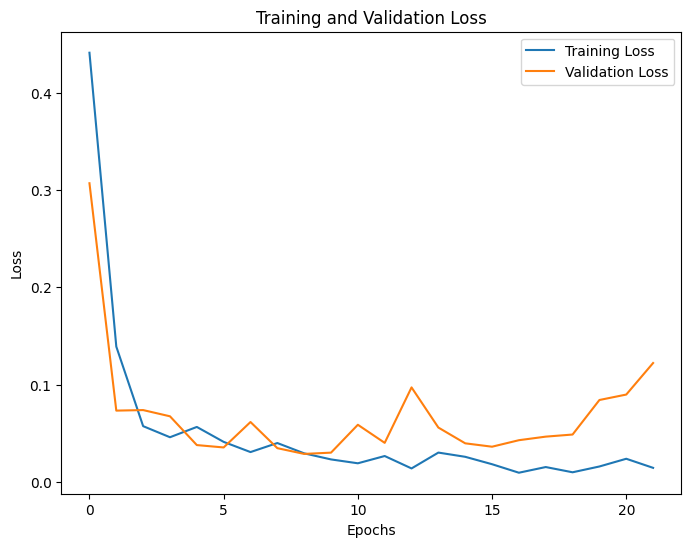

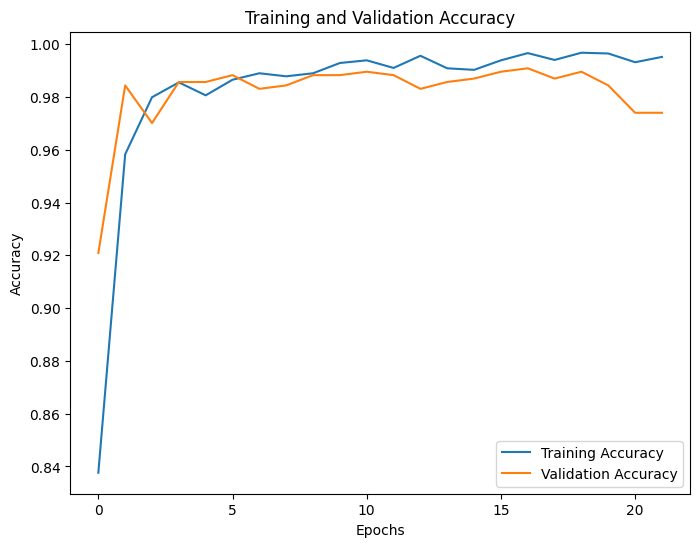

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9852 - loss: 0.0627
Test accuracy (CNN): 98.36627244949341%
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3025
           1       0.99      0.92      0.96       770

    accuracy                           0.98      3795
   macro avg       0.99      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



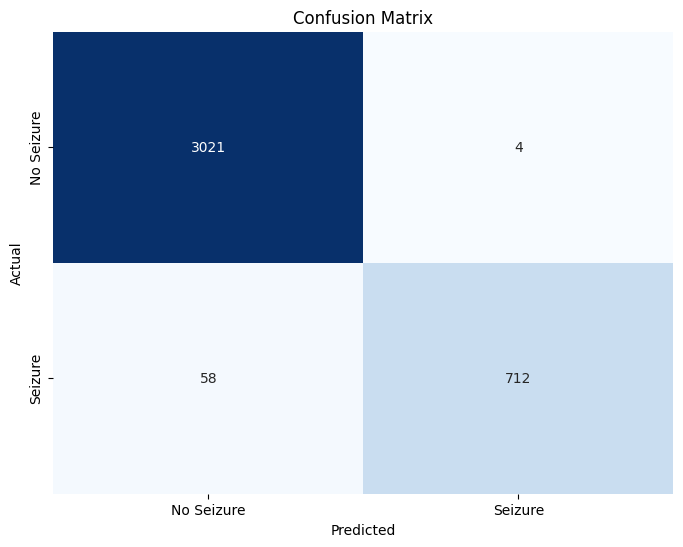

In [49]:
#CNN
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=7, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
    
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]
model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc_cnn = model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 178, 64)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 178, 64)   │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 178, 64)   │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 178, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 178, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 178, 64)   │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 178, 64)   │     12,352 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 178, 64)   │          0 │ activation[0][0], │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 178, 64)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 178, 64)   │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 178, 64)   │     12,352 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 178, 64)   │          0 │ activation_1[0][… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 178, 64)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 178, 64)   │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,489 (404.25 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6017 - loss: 25.0105 - val_accuracy: 0.9040 - val_loss: 0.4009
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8082 - loss: 0.6957 - val_accuracy: 0.9066 - val_loss: 0.2971
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9134 - loss: 0.3029 - val_accuracy: 0.9364 - val_loss: 0.2099
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9409 - loss: 0.2064 - val_accuracy: 0.9637 - val_loss: 0.1517
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9574 - loss: 0.1514 - val_accuracy: 0.9559 - val_loss: 0.1396
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9621 - loss: 0.1299 - val_accuracy: 0.9235 - val_loss: 0.2284
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9607 - loss: 0.1344 - val_accuracy: 0.9533 - val_loss: 0.1345
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9608 - loss: 0.1341 - val_acc

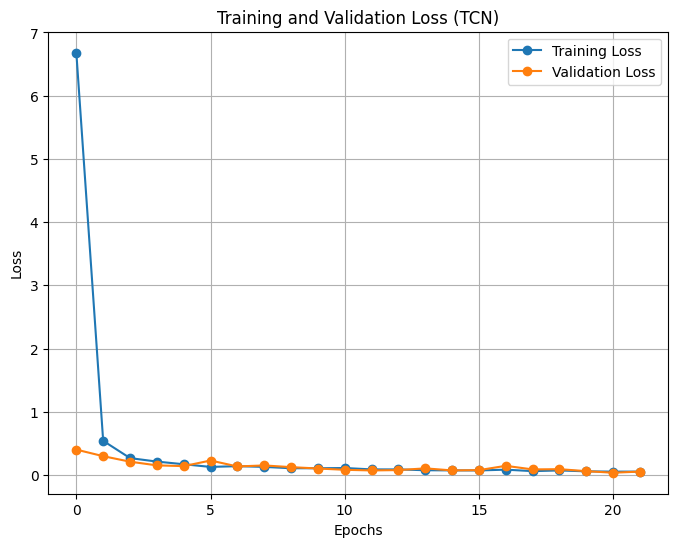

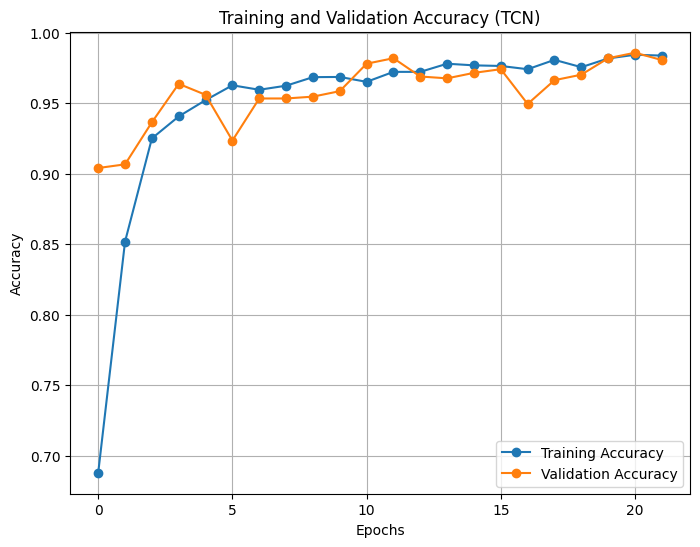

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9799 - loss: 0.0523
Test accuracy (TCN): 97.97%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report (TCN):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3025
           1       1.00      0.90      0.95       770

    accuracy                           0.98      3795
   macro avg       0.99      0.95      0.97      3795
weighted avg       0.98      0.98      0.98      3795



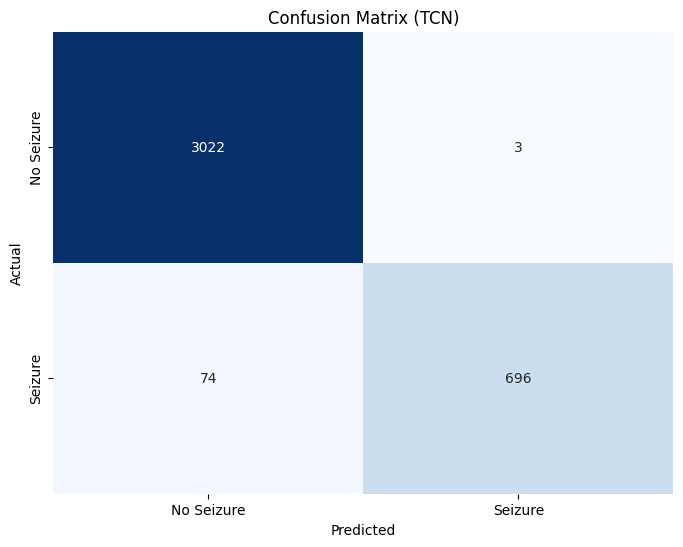

In [5]:
# Reshape data for TCN model
from tensorflow.keras import initializers
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

# Now, train_data.shape will be (7705, 52, 1)
# and test_data.shape will be (3795, 52, 1)

def create_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    """
    Creates a Temporal Convolutional Network (TCN) model.
    
    Parameters:
    - input_shape: tuple, shape of the input data (timesteps, features)
    - num_filters: int, number of filters for the Conv1D layers
    - kernel_size: int, size of the convolutional kernel
    - num_blocks: int, number of residual blocks
    - dropout_rate: float, dropout rate for regularization
    
    Returns:
    - model: Compiled TCN model
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        # First Conv1D layer in the residual block
        conv1 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(x)
        conv1 = layers.Dropout(dropout_rate)(conv1)
        
        # Second Conv1D layer in the residual block
        conv2 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(conv1)
        conv2 = layers.Dropout(dropout_rate)(conv2)
        
        # Residual connection
        if x.shape[-1] != conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, conv2])
        x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create TCN model
tcn_model = create_tcn(input_shape)

# Compile the model
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
tcn_model.summary()

# Train the model
history = tcn_model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_tcn = tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (TCN): {test_acc_tcn*100:.2f}%')

# Predict on test data
predictions = tcn_model.predict(test_data)
predictions_binary = (predictions > 0.50).astype(int)

# Classification Report
print("Classification Report (TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 178, 32)   │        128 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 89, 32)    │          0 │ conv1d_39[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 89, 64)    │      6,208 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 44, 64)    │          0 │ conv1d_40[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 44, 64)    │     12,352 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 44, 64)    │          0 │ conv1d_41[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 44, 64)    │     12,352 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 44, 64)    │          0 │ conv1d_42[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 44, 64)    │          0 │ max_pooling1d_7[… │
│                     │                   │            │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 44, 64)    │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 44, 64)    │     12,352 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 44, 64)    │          0 │ conv1d_43[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 44, 64)    │     12,352 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 44, 64)    │          0 │ conv1d_44[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 44, 64)    │          0 │ activation_16[0]… │
│                     │                   │            │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 44, 64)    │          0 │ add_17[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 44, 64)    │     12,352 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 44, 64)    │          0 │ conv1d_45[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 121,793 (475.75 KB)

 Trainable params: 121,793 (475.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6970 - loss: 2.5733 - val_accuracy: 0.8768 - val_loss: 0.4719
Epoch 2/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9529 - loss: 0.1875 - val_accuracy: 0.9728 - val_loss: 0.0881
Epoch 3/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9642 - loss: 0.1233 - val_accuracy: 0.9780 - val_loss: 0.0666
Epoch 4/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9753 - loss: 0.0772 - val_accuracy: 0.9818 - val_loss: 0.0419
Epoch 5/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9791 - loss: 0.0579 - val_accuracy: 0.9767 - val_loss: 0.0881
Epoch 6/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9821 - loss: 0.0454 - val_accuracy: 0.9805 - val_loss: 0.0562
Epoch 7/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9792 - loss: 0.0628 - val_accuracy: 0.9935 - val_loss: 0.0253
Epoch 8/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9853 - loss: 0.0436 - val_accu

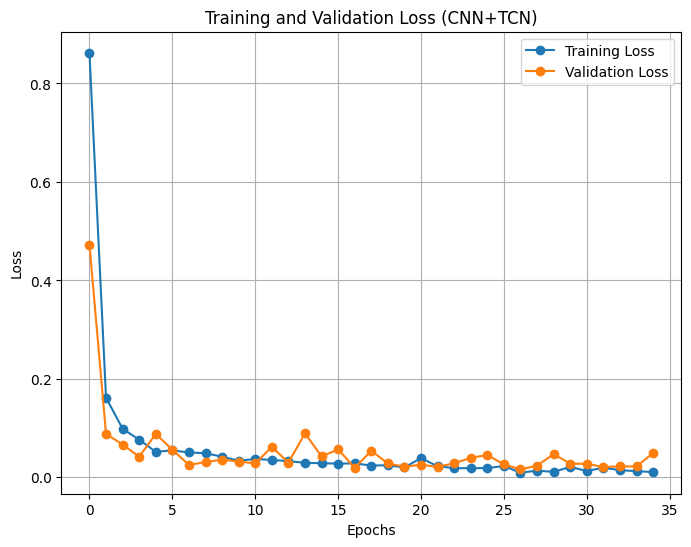

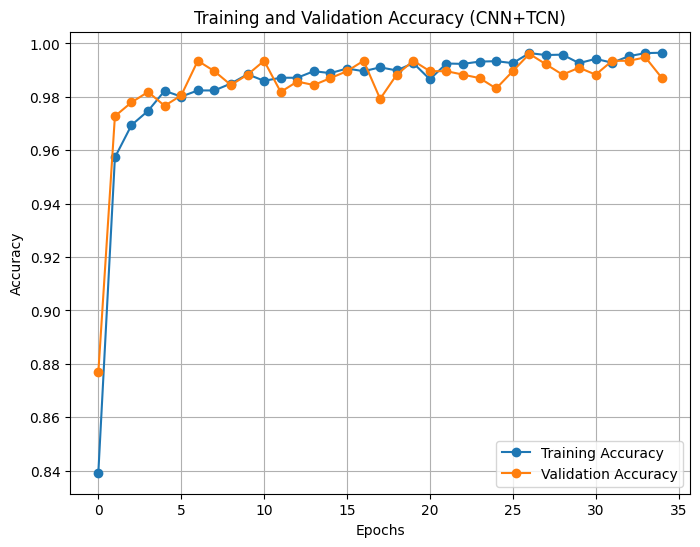

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9915 - loss: 0.0346
Test accuracy (CNN+TCN): 98.92%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report (CNN+TCN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3025
           1       0.98      0.96      0.97       770

    accuracy                           0.99      3795
   macro avg       0.99      0.98      0.98      3795
weighted avg       0.99      0.99      0.99      3795



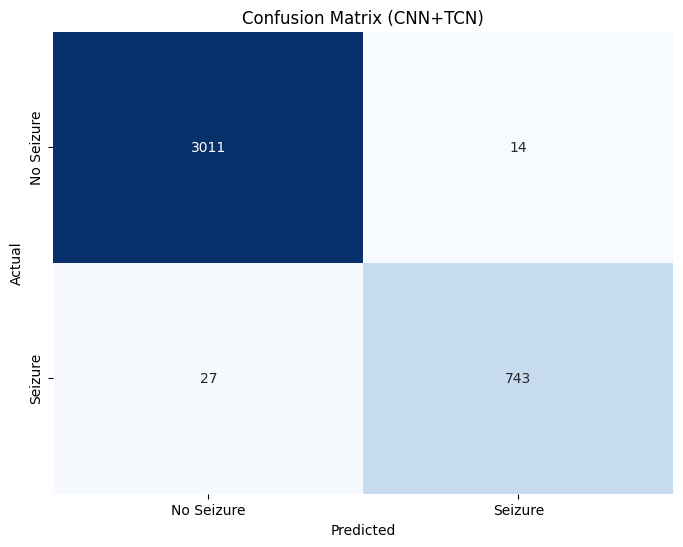

In [9]:
# Reshape data if necessary
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

def create_cnn_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    
    # CNN part
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # TCN part
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        tcn_conv1 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(x)
        tcn_conv1 = layers.Dropout(dropout_rate)(tcn_conv1)
        
        tcn_conv2 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(tcn_conv1)
        tcn_conv2 = layers.Dropout(dropout_rate)(tcn_conv2)
        
        if x.shape[-1] != tcn_conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, tcn_conv2])
        x = layers.Activation('relu')(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create CNN+TCN model
cnn_tcn_model = create_cnn_tcn(input_shape)

# Compile the model
cnn_tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn_tcn_model.summary()

# Train the model
history = cnn_tcn_model.fit(train_data, train_labels, epochs=35, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_cnn_tcn = cnn_tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN+TCN): {test_acc_cnn_tcn*100:.2f}%')

# Predict on test data
predictions = cnn_tcn_model.predict(test_data)
predictions_binary = (predictions > 0.5).astype(int)

# Classification Report
print("Classification Report (CNN+TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (CNN+TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()